# CIP - Demonstração

In [1]:
import cip
print(dir(cip))  # deve conter: 'cifrar', 'decifrar', 'assinar', 'verificar'


['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_core', '_internals', 'assinar', 'cifrar', 'decifrar', 'verificar']


In [2]:
%%time
# CIP — Demonstração Completa: cifragem, assinatura, verificação e corrupção de 1 bit

import cip
import numpy as np
import copy

# ================================
# 1. Dados binários simulados
# ================================
mensagem = "Tudo vale a pena se a alma não é pequena."
dados = mensagem.encode("utf-8")  # Garantir entrada em bytes

print(f"\nOriginal: {mensagem}")

# ================================
# 2. Cifragem + exportação
# ================================
pacote = cip.cifrar(dados)

# Exportação usando função interna (não exposta na API principal)
from cip._internals import _empacotar_para_envio as empacotar
empacotar(pacote, "../dados/demo_cifrado.npz", incluir_offset=False)  # offset omitido por segurança

# ================================
# 3. Assinatura dos blocos
# ================================
assinaturas, chave = cip.assinar(dados)
print(f"\nOffset usado: {chave['offset']}")

# ================================
# 4. Verificação da integridade (dados originais)
# ================================
alterados, total = cip.verificar(dados, assinaturas, offset=chave['offset'])
print(f"\nVerificação original: {alterados} / {total} blocos alterados")

# ================================
# 5. Simulação de corrupção de 1 bit
# ================================
dados_corrompidos = bytearray(dados)
dados_corrompidos[0] ^= 0b00000001  # inverte o bit menos significativo do primeiro byte

# ================================
# 6. Verificação após corrupção
# ================================
alterados_corr, total_corr = cip.verificar(bytes(dados_corrompidos), assinaturas, offset=chave['offset'])
print(f"\nVerificação após corrupção: {alterados_corr} / {total_corr} blocos alterados")

# ================================
# 7. Decifração do pacote salvo
# ================================
from cip._internals import _carregar_para_decifrar as carregar
pacote_npz = carregar("../dados/demo_cifrado.npz")
pacote_npz = dict(pacote_npz)
pacote_npz['offset'] = pacote['offset']  # precisa do offset para decifrar

recuperado = cip.decifrar(pacote_npz)

print("\nRecuperado:", recuperado.rstrip(b'\x00').decode("utf-8"))



Original: Tudo vale a pena se a alma não é pequena.

Offset usado: 3706086

Verificação original: 0 / 1 blocos alterados

Verificação após corrupção: 1 / 1 blocos alterados

Recuperado: Tudo vale a pena se a alma não é pequena.
CPU times: user 13.9 s, sys: 699 ms, total: 14.6 s
Wall time: 11.4 s



Hashes SHA-256 da projeção espectral:
Original  : 709a45d55b6f2f621dd676eb7be0830ad9541d5a187d5dabb193e9171a6efe03
Corrompido: 1f1192faf1bae46300518e8de07164658db36a61f3c0cac797575287fbf0024a


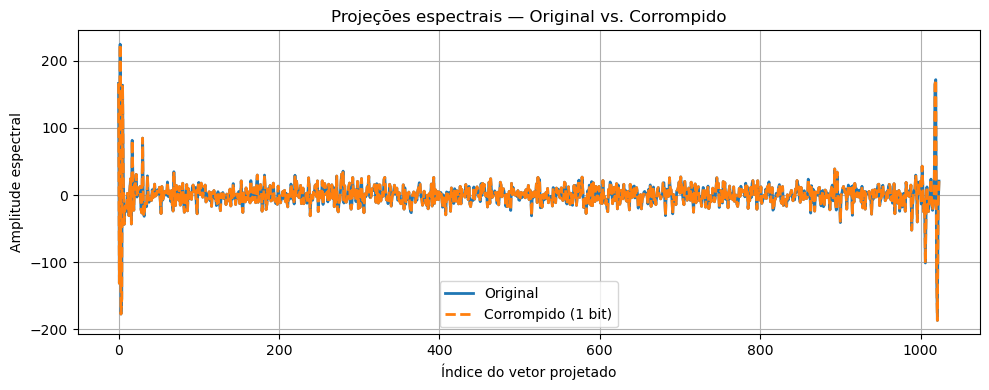

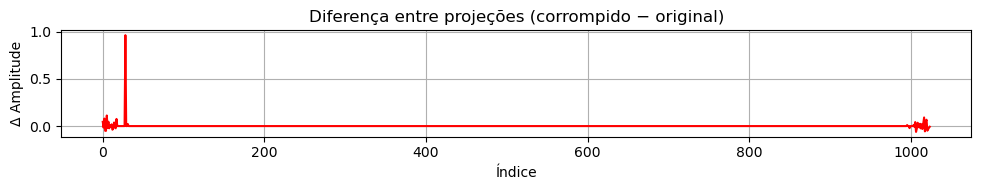

CPU times: user 3.2 s, sys: 175 ms, total: 3.37 s
Wall time: 2.62 s


In [3]:
%%time
import hashlib
import numpy as np
from cip._internals import _carregar_delta_pi, _codificar_bloco, _construir_matriz_cossenos
from numpy.linalg import eigh, pinv

# ================================
# 1. Reconstrói a base harmônica usada
# ================================
offset = chave["offset"]
size = chave["size"]

delta_array = _carregar_delta_pi()
F_values = delta_array[offset : offset + size]
x_values = np.arange(5_000_000 + offset, 5_000_000 + offset + size)

C = _construir_matriz_cossenos(F_values, x_values)
_, autovetores = eigh(C)

base = autovetores[:, -size:]
base_inv = pinv(base)

# ================================
# 2. Projeta os vetores original e corrompido
# ================================
vetor_original = _codificar_bloco(dados, size)
vetor_corrompido = _codificar_bloco(bytes(dados_corrompidos), size)

projecao_original = base_inv @ vetor_original
projecao_corrompida = base_inv @ vetor_corrompido

hash_original = hashlib.sha256(projecao_original.astype(np.float32).tobytes()).hexdigest()
hash_corrompido = hashlib.sha256(projecao_corrompida.astype(np.float32).tobytes()).hexdigest()

# ================================
# 3. Exibe hashes
# ================================
print("\nHashes SHA-256 da projeção espectral:")
print(f"Original  : {hash_original}")
print(f"Corrompido: {hash_corrompido}")

assert hash_original != hash_corrompido, "Hashes iguais — falha na detecção espectral!"

# ================================
# 4. Visualiza as projeções espectrais
# ================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(projecao_original, label="Original", linewidth=2)
plt.plot(projecao_corrompida, label="Corrompido (1 bit)", linestyle="--", linewidth=2)
plt.title("Projeções espectrais — Original vs. Corrompido")
plt.xlabel("Índice do vetor projetado")
plt.ylabel("Amplitude espectral")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Diferença vetorial (opcional)
plt.figure(figsize=(10, 2))
plt.plot(projecao_corrompida - projecao_original, color="red")
plt.title("Diferença entre projeções (corrompido − original)")
plt.xlabel("Índice")
plt.ylabel("Δ Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


### Análise gráfica da assinatura espectral

A projeção vetorial da CIP sobre a base harmônica derivada de $\Delta_\pi(x)$ é **extremamente sensível à estrutura interna dos dados**.

O gráfico acima mostra que **a inversão de um único bit no dado original** (flip em apenas 1 byte) é suficiente para **alterar toda a assinatura espectral do bloco**.

A curva inferior destaca essa diferença: uma alteração microscópica nos dados brutos provoca uma **distorção vetorial global**.

Esse comportamento **não é genérico** — ele depende da estrutura oscilatória específica de $\Delta_\pi(x)$, que atua como uma base espectral ressonante.

A CIP não apenas verifica integridade binária:  
ela realiza uma **escuta vetorial da integridade espectral**.

**Projeto DELTA**  
*Rede Dual de Autovalores para Aritmética Transformativa*  
<sub>Dual Eigenvalue Lattice for Transformative Arithmetic</sub>
